In [34]:
import numpy as np

#from assets.keras.keras.datasets import shapes_3d
from assets.keras.keras.preprocessing.image import ImageDataGenerator
from assets.keras.keras.models import Sequential
from assets.keras.keras.layers.core import Dense, Dropout, Activation, Flatten
from assets.keras.keras.layers.convolutional import Convolution3D, MaxPooling3D, ZeroPadding3D
from assets.keras.keras.optimizers import SGD, Adam
from assets.keras.keras.utils import np_utils, generic_utils
from assets.keras.keras.regularizers import l2
import theano
import matplotlib.pyplot as plt
from assets.vis_utils import *
%matplotlib nbagg
%load_ext autoreload
%autoreload 2

#load dataset from gen_dataset
import cPickle as pickle

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [57]:
from assets.gen_motion import gen_dataset
import math
#gen_dataset(size, N, obj_type, obj_theta, obj_vel, types, velocity, theta, coherence, dots, directions(opt))
X_train1,Y_train1,X_test1,Y_test1 = gen_dataset((16,32,32),200,'square', (5,5,0), 0, 1,['translate'],[1],[0],[0],[150],[0])
X_train2,Y_train2,X_test2,Y_test2 = gen_dataset((16,32,32),200,'circle', (11,11,3), 0, 1,['translate'],[1],[0],[0],[150],[0])

X_train = np.concatenate((X_train1,X_train2),axis=0)
Y_train = np.concatenate((Y_train1,Y_train2))
X_test = np.concatenate((X_test1,X_test2))
Y_test = np.concatenate((Y_test1,Y_test2))

print 'Train data shape: ', X_train.shape
print 'Train labels shape: ', Y_train.shape
print 'Test data shape: ', X_test.shape
print 'Test labels shape: ', Y_test.shape

###
#X_train = X_train[0:200,:,:,:,:]
#Y_train = Y_train[0:200]
#X_val = X_val[0:40,:,:,:,:]
#Y_val = Y_val[0:40]
# convert class vectors to binary class matrices

#Y_train/=math.pi
#Y_test/=math.pi
Y_train = np_utils.to_categorical(Y_train[:,6]-1, 2)
Y_test = np_utils.to_categorical(Y_test[:,6]-1, 2)

Train data shape:  (360, 1, 16, 32, 32)
Train labels shape:  (360, 7)
Test data shape:  (40, 1, 16, 32, 32)
Test labels shape:  (40, 7)


<IPython.core.display.Javascript object>


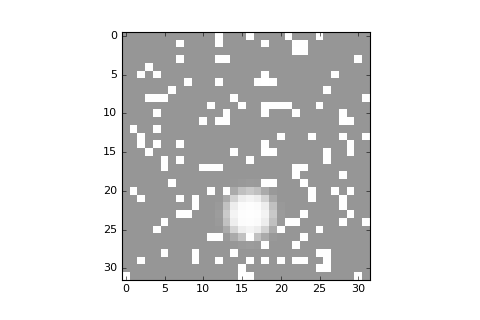

In [53]:
visualize_matrix(X_train[25,0,:,:,:],interval_len = 50, ubound=255)

In [54]:

print('X_train shape:', X_train.shape)
print('Y_train shape:', Y_train.shape)
print('X_test shape:', X_test.shape)
print('Y_test shape:', Y_test.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

('X_train shape:', (36, 1, 16, 32, 32))
('Y_train shape:', (36, 2))
('X_test shape:', (4, 1, 16, 32, 32))
('Y_test shape:', (4, 2))
(36, 'train samples')
(4, 'test samples')


In [ ]:

# CNN Training parameters
batch_size = 20
nb_classes = 2
nb_epoch = 200


# number of convolutional filters to use at each layer
nb_filters = [2,4,8]

# level of pooling to perform at each layer (POOL x POOL)
nb_pool = [2,2,2]

# level of convolution to perform at each layer (CONV x CONV)
nb_conv = [3,3,3]

# Regularization
reg = 1e-4

model = Sequential()
#model.add(ZeroPadding3D((1,1,1),))
model.add(Convolution3D(nb_filters[0],len_conv_dim1=nb_conv[0], len_conv_dim2=nb_conv[0], len_conv_dim3=nb_conv[0], border_mode='valid',
                         activation='relu', W_regularizer=l2(reg),dim_ordering='th',input_shape=(1,16,32,32)))
model.add(MaxPooling3D(pool_size=(1, nb_pool[0], nb_pool[0])))
#model.add(Dropout(0.5))
#model.add(ZeroPadding3D((1,1,1)))
model.add(Convolution3D(nb_filters[1],len_conv_dim1=nb_conv[1], len_conv_dim2=nb_conv[1], len_conv_dim3=nb_conv[1], border_mode='valid',
                        activation='relu', W_regularizer=l2(reg)))
#model.add(MaxPooling3D(pool_size=(nb_pool[1], nb_pool[1], nb_pool[1])))
#model.add(Dropout(0.5))
#model.add(ZeroPadding3D((1,1,1)))
model.add(Convolution3D(nb_filters[2],len_conv_dim1=nb_conv[1], len_conv_dim2=nb_conv[1], len_conv_dim3=nb_conv[1], border_mode='valid',
                        activation='relu', W_regularizer=l2(reg)))
model.add(Flatten())
#model.add(Dropout(0.5))
model.add(Dense(4, init='normal', activation='relu', W_regularizer=l2(reg)))
model.add(Dense(nb_classes, init='normal', W_regularizer=l2(reg)))
model.add(Activation('softmax'))

#Adam
sgd = Adam(lr=1e-3)#, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='mse', optimizer=sgd)

hist = model.fit(X_train, Y_train, batch_size=batch_size, nb_epoch=nb_epoch, show_accuracy=True, verbose=1,
          validation_split=.1)
scoretr = model.evaluate(X_train, Y_train, batch_size=batch_size, show_accuracy=True)
#scoreva = model.evaluate(X_val, Y_val, batch_size=batch_size, show_accuracy=True)
scorete = model.evaluate(X_test, Y_test, batch_size=batch_size, show_accuracy=True)
print('Train loss:', scoretr[0])
print('Train accuracy:', scoretr[1])
#print('Val loss:', scoreva[0])
#print('Val accuracy:', scoreva[1])
print('Test loss:', scorete[0])
print('Test accuracy:', scorete[1])

<IPython.core.display.Javascript object>


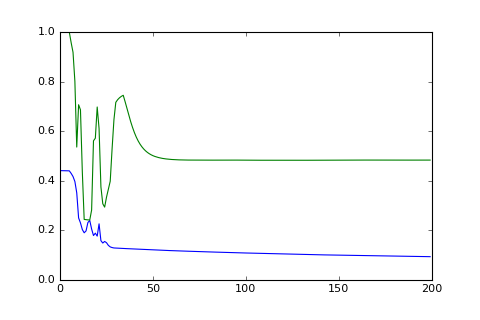

In [56]:
plt.plot(np.asarray(model.history.history['loss'])[0:500])
plt.plot(np.asarray(model.history.history['val_loss'])[0:500])